In [23]:
# -*- coding: utf-8 -*-
import sys
sys.path.append('/home/jun/PersonReID')
# Set your CAM extractor
from torchcam.methods import SmoothGradCAMpp
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import scipy.io
import yaml
import math
from tqdm import tqdm
from model import *
from utils.utils import fuse_all_conv_bn
#from LATransformer.model import ClassBlock, LATransformer, LATransformerTest
#from LATransformer.utils import save_network, update_summary
import matplotlib.pyplot as plt
from pathlib import Path
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image  

######################################################################
# Options
# --------

parser = argparse.ArgumentParser(description='Test')
parser.add_argument('--gpu_ids',default='0', type=str,help='gpu_ids: e.g. 0  0,1,2  0,2')
parser.add_argument('--which_epoch',default='last', type=str, help='0,1,2,3...or last')
parser.add_argument('--data_dir',default='/home/jun/ReID_Dataset/cuhk03/dataloader_new_detected',type=str, help='./test_data')
parser.add_argument('--name', default='ft_ResNet50', type=str, help='save model path')
parser.add_argument('--batchsize', default=256, type=int, help='batchsize')
parser.add_argument('--linear_num', default=512, type=int, help='feature dimension: 512 or default or 0 (linear=False)')
parser.add_argument('--use_dense', action='store_true', help='use densenet121' )
parser.add_argument('--use_efficient', action='store_true', help='use efficient-b4' )
parser.add_argument('--use_hr', action='store_true', help='use hr18 net' )
parser.add_argument('--cuhk03', action='store_true', help='use PCB' )
parser.add_argument('--PCB', action='store_true', help='use PCB' )
parser.add_argument('--use_latrans', action='store_true', help='use LA_Transformer' )
parser.add_argument('--use_vit', action='store_true', help='use Vision Transformer (ViT)' )
parser.add_argument('--multi', action='store_true', help='use multiple query' )
parser.add_argument('--fp16', action='store_true', help='use fp16.' )
parser.add_argument('--ibn', action='store_true', help='use ibn.' )
parser.add_argument('--ms',default='1', type=str,help='multiple_scale: e.g. 1 1,1.1  1,1.1,1.2')
parser.add_argument('--dataset', default='market1501', type=str, help='Datataset for visulization')
opt = parser.parse_args(['--dataset', 'duke'])

id_list = [4,6,28,52,54,102]
#id_list = list(range(15,20))
start = 52
limits = 3

color_list = ['b','g','r','c','m','y']
marker_list = ['o','v','^','p']
model_path = Path(f'{sys.path[-1]}/model') 
result_paths= list(model_path.glob(f'*/*.txt'))

model_results = {}


class model_result():
    def __init__(self):
        self.data = {'label':[],
                     'pred':[],
                     'rgb_img':[],
                     'visualization':[]}
        
    def add_element(self, data_type, data, img_name=None):
        type_list = ['label', 'pred', 'visualization']
        if data_type in type_list:
            self.data[data_type].append(data)
        elif data_type == 'rgb_img':
            self.data['rgb_img'].append([img_name,data]) 
        else:
            print(f'No {data_type} in self.data keys')
            
image_results = {}
class image_result():
    def __init__(self, label, rgb_img):
        self.data = {'Original':[rgb_img,label]}
        
    def add_element(self, model_name, img, label):
        self.data.update({model_name:[img,label]})
        
class score_result:
    def __init__(self, rank1, rank5, rank10, map):
        self.rank1 = rank1
        self.rank5 = rank5 
        self.rank10 = rank10 
        self.map = map

In [24]:
result_path_dict = {}
test_types = ['market_market', 'market_cuhk03', 'market_duke', 'cuhk03_market', 'cuhk03_cuhk03', 'cuhk03_duke', 'duke_market', 'duke_cuhk03', 'duke_duke']
for test_type in test_types:
    result_path_dict[test_type] = []
for path in result_paths:
    for test_type in test_types:
        if path.name.find(test_type) != -1:
            result_path_dict[test_type].append(path)

In [25]:
all_score_result_dic = {}
model_list_sorted = []
for test_name, result_path_all in result_path_dict.items():
    if test_name.split('_')[0] == opt.dataset:
        score_result_dict = {}
        for result_path in result_path_all:
            model_name = result_path.parents[0].name.split("_")[0]
            (rank1, rank5, rank10, map) = open(result_path).readlines()[-1].strip().split(' ')
            rank1 = float(rank1.split(':')[1])
            rank5 = float(rank5.split(':')[1])
            rank10 = float(rank10.split(':')[1])
            map = float(map.split(':')[1])
            score_result_dict.update({model_name : score_result(rank1, rank5, rank10, map)})
        sorted_score_result = dict(sorted(score_result_dict.items(), key=lambda item: item[1].map))
        if test_name.split('_')[0] == test_name.split('_')[1]:
            model_list_sorted = list(sorted_score_result.keys())
        all_score_result_dic.update({test_name: sorted_score_result})

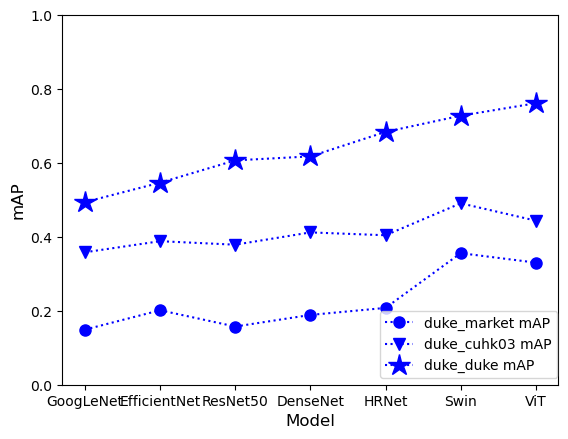

In [26]:
test_num = 0
for test_name , sorted_score_result in all_score_result_dic.items():
    rank1_list = []
    rank5_list = []
    rank10_list = []
    map_list = []
    for model_name in model_list_sorted:
        rank1_list.append(sorted_score_result[model_name].rank1)
        rank5_list.append(sorted_score_result[model_name].rank5)
        rank10_list.append(sorted_score_result[model_name].rank10)
        map_list.append(sorted_score_result[model_name].map)
    #rank1_list = [x.rank1 for sorted_score_result[model_name].rank1 in sorted_score_result.values()]
    #rank5_list = [x.rank5 for x in sorted_score_result.values()]
    #rank10_list = [x.rank10 for x in sorted_score_result.values()]
    #map_list = [x.map for x in sorted_score_result.values()]
    labels = model_list_sorted
    #plt.figure(figsize=(30,10)) 
    if test_name.split('_')[0] == test_name.split('_')[1]: 
        plt.plot(labels, map_list, ':b*', markersize='16', label=f'{test_name} mAP')
    else:
        plt.plot(labels, map_list, f':b{marker_list[test_num]}', markersize='8', label=f'{test_name} mAP')
        test_num += 1
    #plt.plot(labels, rank1_list, f':{color_list[test_num]}o', markersize='8', label=f'{test_name} Rank@1')
    
    plt.legend(bbox_to_anchor=(0.998, 0.2), loc='upper right', borderaxespad=0, fontsize=10)
    if opt.dataset == 'market':
        plt_title = 'Market1501'
    if opt.dataset == 'duke':
        plt_title = 'DukeMTMC'
    if opt.dataset == 'cuhk03':
        plt_title = 'CUHK03'
    #plt.title(f"{plt_title} benchmark", fontsize = 16)
    plt.xlabel("Model", fontsize = 12)
    plt.ylabel("mAP", fontsize = 12)
    plt.axis([None, None, 0, 1])
    result_save_dir = f'./result_fig/{opt.dataset}'
    os.makedirs(result_save_dir, exist_ok=True)
    plt.savefig(os.path.join(result_save_dir,'Score.jpg'))
    #plt.show()


In [27]:
model_names = model_list_sorted
for model_name in model_names:
    print(f'Procesing model: {model_name}')
    opt.name = model_name + '_all_trick_' + opt.dataset
    ###load config###
    # load the training config
    config_path = os.path.join('../model',opt.name,'opts.yaml')
    with open(config_path, 'r') as stream:
            config = yaml.load(stream, Loader=yaml.FullLoader) # for the new pyyaml via 'conda install pyyaml'
    opt.fp16 = config['fp16']
    opt.arcface = config['arcface']
    opt.circle = config['circle']
    opt.cosface = config['cosface']
    opt.contrast = config['contrast']
    opt.instance = config['instance']
    opt.triplet = config['triplet']
    opt.lifted = config['lifted']
    opt.sphere = config['sphere'] 
    if 'centroid' in config:      
        opt.centroid = config['centroid']        
    else:
        opt.centroid = False
    
    opt.use_dense = config['use_dense']
    opt.use_NAS = config['use_NAS']
    opt.stride = config['stride']
    if 'use_swin' in config:
        opt.use_swin = config['use_swin']
    else:
        opt.use_swin = False 
    if 'use_swinv2' in config:
        opt.use_swinv2 = config['use_swinv2']
    else:
        opt.use_swinv2 = False
    if 'use_convnext' in config:
        opt.use_convnext = config['use_convnext']
    else:
        opt.use_convnext = False
    if 'use_efficient' in config:
        opt.use_efficient = config['use_efficient']
    else:
        opt.use_efficient = False
    if 'use_hr' in config:
        opt.use_hr = config['use_hr']
    else:
        opt.use_hr = False
    if 'use_vit' in config:
        opt.use_vit = config['use_vit']
    else:
        opt.use_vit = False
    if 'use_vitraw' in config:
        opt.use_vitraw = config['use_vitraw']
    else:
        opt.use_vitraw = False
    if 'use_latrans' in config:
        opt.use_latrans = config['use_latrans']
    else:
        opt.use_latrans = False
    if 'use_latransv2' in config:
        opt.use_latransv2 = config['use_latransv2']
    else:
        opt.use_latransv2 = False
    if 'use_laswin' in config:
        opt.use_laswin = config['use_laswin']
    else:
        opt.use_laswin = False
    if 'use_caswin' in config:
        opt.use_caswin = config['use_caswin']
    else:
        opt.use_caswin = False
    if 'use_laswinv2' in config:
        opt.use_laswinv2 = config['use_laswinv2']
    else:
        opt.use_laswinv2 = False
    if 'ABS' in config:
        opt.ABS = config['ABS']
    else:
        opt.ABS = False  
    if 'PCB' in config:
        opt.PCB = config['PCB']
    else:
        opt.PCB = False

    if 'O2LS' in config:
        opt.O2LS = config['O2LS']
    else:
        opt.O2LS = False  

    if 'use_lenet' in config:
        opt.use_lenet = config['use_lenet']
    else:
        opt.O2LS = False  
    if 'nclasses' in config: # tp compatible with old config files
        opt.nclasses = config['nclasses']
    else: 
        opt.nclasses = 751 
    if 'ibn' in config:
        opt.ibn = config['ibn']
    if 'linear_num' in config:
        opt.linear_num = config['linear_num']
    str_ids = opt.gpu_ids.split(',')
    #which_epoch = opt.which_epoch
    name = opt.name
    if 'data_dir' in config:
        opt.data_dir = config['data_dir']
    if opt.dataset == 'market':
        opt.data_dir = '/home/jun/ReID_Dataset/market/dataloader'
    elif opt.dataset == 'duke':
        opt.data_dir = '/home/jun/ReID_Dataset/duke/dataloader'
    elif opt.dataset == 'cuhk03':
        opt.data_dir = '/home/jun/ReID_Dataset/cuhk03/dataloader_new_detected'
    else:
        pass
    data_dir = opt.data_dir
    if 'cuhk03' in config:
        opt.cuhk03 = config['cuhk03']
    opt.droprate = config['droprate']
    gpu_ids = []
    for str_id in str_ids:
        id = int(str_id)
        if id >=0:
            gpu_ids.append(id)

    str_ms = opt.ms.split(',')
    ms = []
    for s in str_ms:
        s_f = float(s)
        ms.append(math.sqrt(s_f))

    # set gpu ids
    if len(gpu_ids)>0:
        torch.cuda.set_device(gpu_ids[0])
        cudnn.benchmark = True

    ######################################################################
    # Load Data
    # ---------
    #
    # We will use torchvision and torch.utils.data packages for loading the
    # data.
    #
    
    h, w = 224, 224
    transform_train_list = [
            #transforms.RandomResizedCrop(size=128, scale=(0.75,1.0), ratio=(0.75,1.3333), interpolation=3), #Image.BICUBIC)
            transforms.Resize((h, w), interpolation=3),
            transforms.ToTensor(),
            ]

    transform_val_list = [
            transforms.Resize(size=(h, w),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            ]
    data_transforms = {
        'train': transforms.Compose( transform_train_list ),
        'val': transforms.Compose(transform_val_list),
    }
    normalize = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

    if opt.PCB:
        transform_train_list = [
            transforms.Resize((384,192), interpolation=3),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
            ]
        transform_val_list = [
            transforms.Resize(size=(384,192),interpolation=3), #Image.BICUBIC
            transforms.ToTensor()
            ]

    image_datasets = {}
    image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                            data_transforms['train'])
    image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'train_val/val'),
                                            data_transforms['val'])

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=opt.batchsize,
                                                shuffle=True, num_workers=2, pin_memory=True,
                                                prefetch_factor=2, persistent_workers=True) # 8 workers may work faster
                for x in ['train', 'val']}
    class_names = image_datasets['val'].classes
    use_gpu = torch.cuda.is_available()

    ######################################################################
    # Load model
    #---------------------------
    def load_network(network):
        save_path = os.path.join('../model',name,'net_%s.pth'%opt.which_epoch)
        network.load_state_dict(torch.load(save_path))
        return network

    ######################################################################
    # Load Collected data Trained model
    return_feature = opt.arcface or opt.cosface or opt.circle or opt.triplet or opt.contrast or opt.instance or opt.lifted or opt.sphere or opt.centroid
    if opt.use_dense:
        print(f'Loading Densenet')
        model_structure = ft_net_dense(opt.nclasses, stride = opt.stride, linear_num=opt.linear_num)
    elif opt.use_lenet:
        model_structure = GoogLeNet(opt.nclasses)
    elif opt.use_NAS:
        print(f'Loading NAS')
        model_structure = ft_net_NAS(opt.nclasses, linear_num=opt.linear_num)
    elif opt.use_swin:
        print(f'Loading Swin')
        model_structure = Swin(opt.nclasses, linear_num=opt.linear_num)
    elif opt.use_swinv2:
        model_structure = ft_net_swin(opt.nclasses,  linear_num=opt.linear_num)
    elif opt.use_convnext:
        print(f'Loading Convnext')
        model_structure = ft_net_convnext(opt.nclasses, linear_num=opt.linear_num)
    elif opt.use_efficient:
        print(f'Loading Efficient')
        model_structure = ft_net_efficient(opt.nclasses, linear_num=opt.linear_num)
    elif opt.use_hr:
        print(f'Loading hrNet')
        model_structure = ft_net_hr(opt.nclasses, linear_num=opt.linear_num)
    elif opt.use_latrans:
        print(f'Loading LATransformer')
        model_structure = LATransformer(opt.nclasses, linear_num=256)
    elif opt.use_vit:
        print(f'Loading ViT')
        model_structure = ViTReID(opt.nclasses, linear_num=opt.linear_num)
    elif opt.use_laswin:
        model_structure = LASwin(len(class_names), opt.droprate, opt.stride, circle = return_feature, linear_num=opt.linear_num, vertical=True)
    elif opt.use_laswinv2:
        model_structure = LASwin(len(class_names), opt.droprate, opt.stride, circle = return_feature, linear_num=opt.linear_num, vertical=False)
    elif opt.use_caswin:
        model_structure = CASwin(len(class_names), opt.droprate, opt.stride, circle = return_feature, linear_num=opt.linear_num)
    elif opt.ABS:
        model_structure = ABSwin(opt.nclasses, linear_num=opt.linear_num, circle = False)
    elif opt.O2LS:
        model_structure = O2LSwin(opt.nclasses, linear_num=opt.linear_num, circle = return_feature)
        opt.linear_num = 1024
    elif opt.PCB:
        print(f'Loading PCB')
        model_structure = PCB(len(class_names), global_circle = return_feature, local_circle=False, linear_num=opt.linear_num)
    else:
        print(f'Loading ResNet')
        model_structure = ft_net(opt.nclasses, stride = opt.stride, ibn = opt.ibn, linear_num=opt.linear_num)
    
        

    #if opt.fp16:
    #    model_structure = network_to_half(model_structure)

    model = load_network(model_structure).cuda()
    if opt.use_laswin:
        try:
            model.classifier = nn.Sequential()
        except:
            pass
    model_results[model_name] = model_result()
    
    # Create visualization image object
    for id, (rgb_img, label) in enumerate(image_datasets['val']):
        if id in id_list: # Take first 
            input_tensor = normalize(rgb_img).unsqueeze(0).cuda()
            rgb_img = np.float32(rgb_img.permute(1,2,0))
            
            if opt.use_vit:
                #target_layers = [model.blocks[-1].norm1]
                target_layers = [model.norm]
                
                def reshape_transform(tensor, height=14, width=14):
                    #print(tensor.shape)
                    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                        height, width, tensor.size(2))
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = result.transpose(2, 3).transpose(1, 2)
                    #print(result.shape)
                    return result
            elif opt.use_latrans:
                target_layers = [model.model.blocks[-1].norm1]
                
                def reshape_transform(tensor, height=14, width=14):
                    #print(tensor.shape)
                    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                        height, width, tensor.size(2))
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = result.transpose(2, 3).transpose(1, 2)
                    #print(result.shape)
                    return result
            elif opt.ABS:
                target_layers = [model.layers[-1].blocks[-1].norm1]
                def reshape_transform(tensor, height=7, width=7):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif opt.use_swinv2 or opt.use_laswin or opt.use_laswinv2 or opt.use_caswin:
                target_layers = [model.model.layers[-1].blocks[-1].norm1]
                def reshape_transform(tensor, height=7, width=7):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif opt.use_swin:
                target_layers = [model.layers[-1].blocks[-1].norm1]
                def reshape_transform(tensor, height=7, width=7):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif opt.O2LS:
                target_layers = [model.layers[-1].blocks[-1].norm1]
                def reshape_transform(tensor, height=7, width=7):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif opt.use_convnext:
                target_layers = [model.model.stages[-1].blocks[-1]]
                def reshape_transform(tensor):
                    return tensor
            elif opt.use_efficient:
                target_layers = [model.model._conv_head] 
                def reshape_transform(tensor):
                    return tensor
            elif opt.use_hr:
                target_layers = [model.model.final_layer] 
                def reshape_transform(tensor):
                    return tensor  
            elif opt.PCB:
                target_layers = [model.model.layer4[-1]]
                def reshape_transform(tensor):
                    return tensor
            elif opt.use_NAS:
                target_layers = [model.model.cell_5]
                def reshape_transform(tensor):
                    return tensor
            elif opt.use_dense:
                target_layers = [model.model.features.denseblock4]
                def reshape_transform(tensor):
                    return tensor 
            elif opt.use_lenet:
                target_layers = [model.inception5a]
                def reshape_transform(tensor):
                    return tensor 
            else:
                target_layers = [model.model.layer4[-1]]
                def reshape_transform(tensor):
                    return tensor
            #reshape_transform(input_tensor)
            
            cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

            targets = [ClassifierOutputTarget(label)]
            #print(cam)
            
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                eigen_smooth=True,
                                aug_smooth=True)
            resize = transforms.Resize((256, 128), interpolation=3)
            
            # In this example grayscale_cam has only one image in the batch:
            grayscale_cam = grayscale_cam[0, :]
            model_results[model_name].add_element('visualization',resize(torch.from_numpy(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)).permute(2,0,1)).permute(1,2,0))
            model_results[model_name].add_element('label', label)
            #model_results[model_name].add_element('pred', preds.item())
            model_results[model_name].add_element('rgb_img', resize(torch.from_numpy(rgb_img).permute(2,0,1)).permute(1,2,0), str(id))

Procesing model: GoogLeNet


Using cache found in /home/jun/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True i

Procesing model: EfficientNet
Loading Efficient
Loaded pretrained weights for efficientnet-b4
Procesing model: ResNet50
Loading ResNet


/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Procesing model: DenseNet
Loading Densenet


Using cache found in /home/jun/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Procesing model: HRNet
Loading hrNet
Procesing model: Swin
Loading Swin
Procesing model: ViT
Loading ViT


In [28]:
## 
model_name = next(iter(model_results))
data_len = len(model_results[model_name].data["rgb_img"])

for i in range(len(model_results[model_name].data["rgb_img"])):
    
    rgb_img = model_results[model_name].data["rgb_img"][i][1]
    label = model_results[model_name].data["label"][i]
    img_id = model_results[model_name].data["rgb_img"][i][0]
    image_results[img_id] = image_result(label, rgb_img)
    print(f'Initiate {img_id} pic object')
     
for model_name in model_results.keys():
    data_len = len(model_results[model_name].data["rgb_img"]) 
    for i in range(len(model_results[model_name].data["rgb_img"])):
        visualization = model_results[model_name].data["visualization"][i] 
        #pred = model_results[model_name].data["pred"][i]
        img_id = model_results[model_name].data["rgb_img"][i][0]
        image_results[img_id].add_element(model_name, visualization, None)

Initiate 15 pic object
Initiate 16 pic object
Initiate 17 pic object
Initiate 18 pic object
Initiate 19 pic object


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

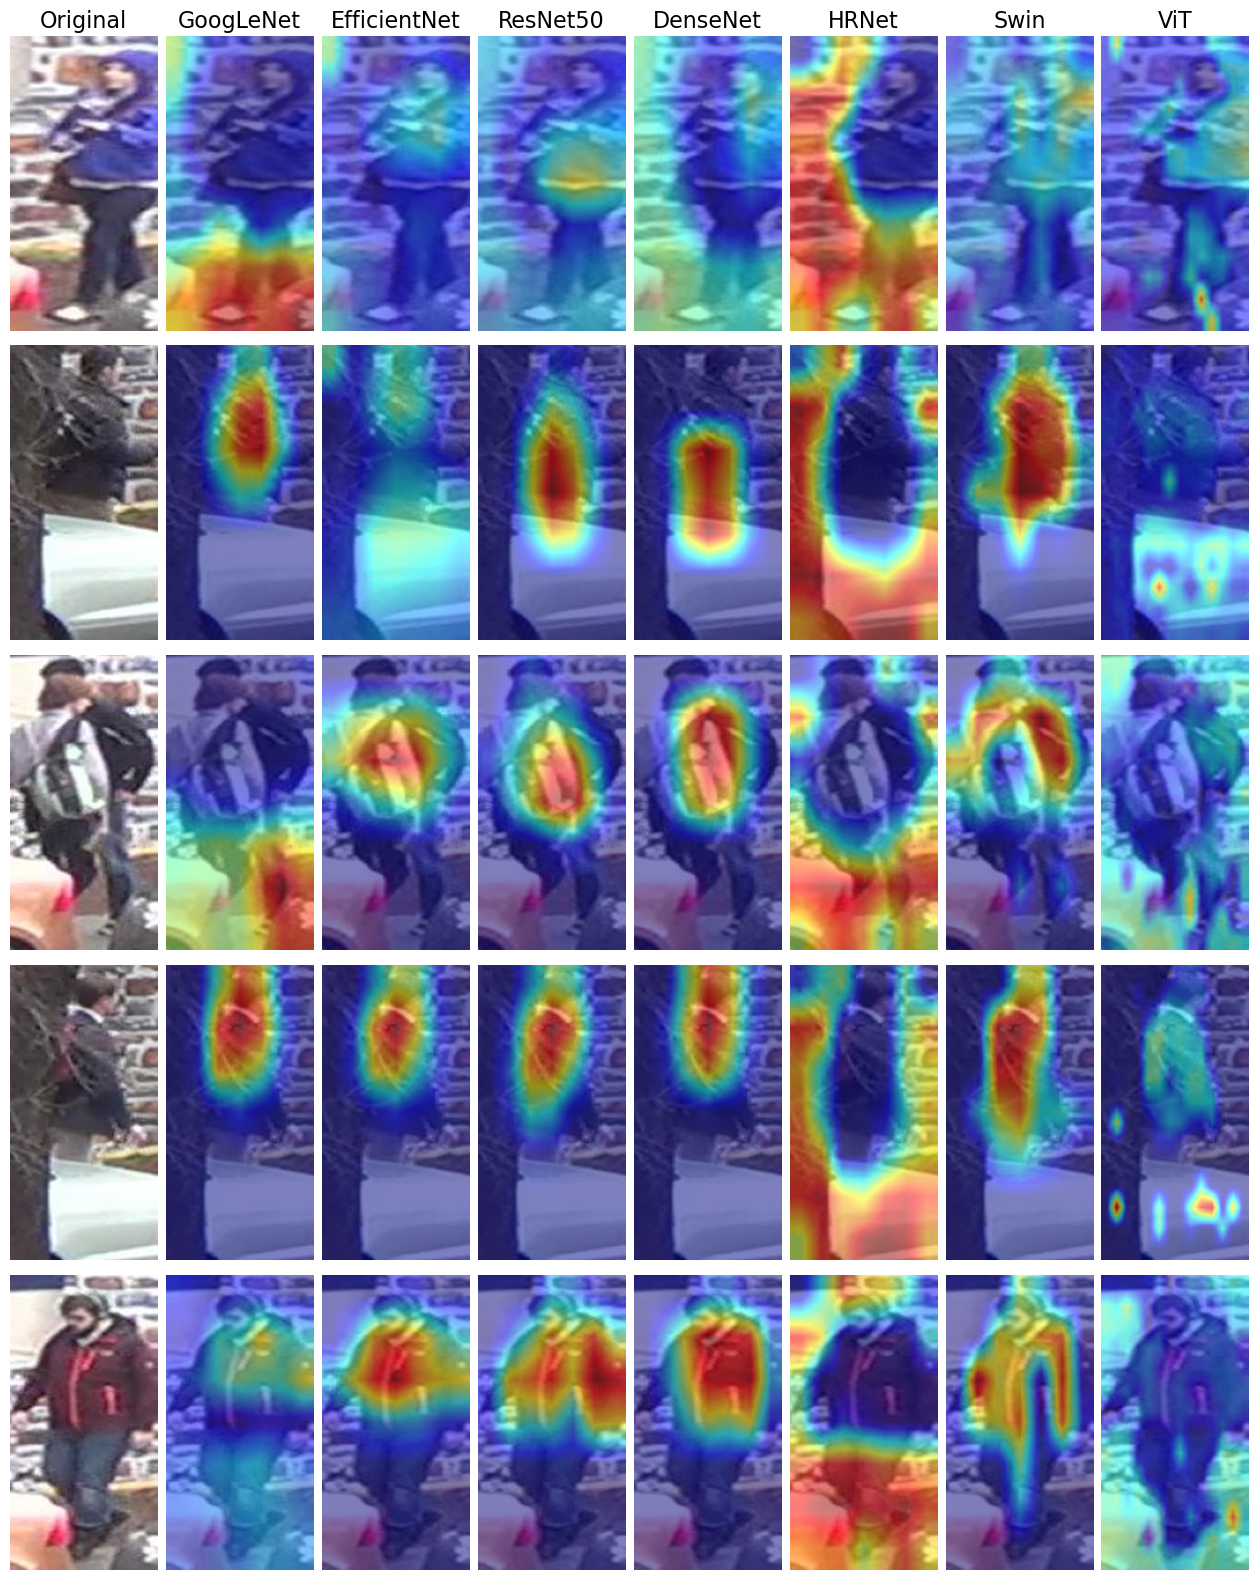

In [29]:
plt.suptitle(f'opt.dataset', fontsize=18, y=0.95)

ncols = len(image_results[next(iter(image_results))].data)
nrows = len(image_results[next(iter(image_results))].data.items())
fig = plt.figure(figsize=(2*ncols, 4*nrows))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for col, (img_id, image_data) in enumerate(image_results.items()):
    for row, (model_name, data) in enumerate(image_data.data.items()):
        position = (col * nrows) + row + 1
        img = data[0]
        label = data[1]
        ax = plt.subplot(ncols, nrows, position)
        ax.imshow(img)
        if col==0:
            ax.set_title(f'{model_name}',fontsize = 16)
        ax.axis(False)
fig.savefig(os.path.join(result_save_dir,'CAM.jpg'))